In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
pd.set_option('display.max_columns', None)
from collections import Counter
import numpy as np
import missingno
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import torch
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from recommenders.models.deeprec.models.graphrec.lightgcn import LightGCN
from sklearn.model_selection import GridSearchCV
from recommenders.models.deeprec.deeprec_utils import prepare_hparams
import dgl

2023-07-18 17:05:06.538985: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 17:05:07.252337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!pip install dgl

In [3]:
pip install missingno

  Using cached missingno-0.5.2-py3-none-any.whl (8.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install missingno

  Using cached missingno-0.5.2-py3-none-any.whl (8.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# cold_data_3= pd.read_csv("cold_data_0.3.csv")
# cold_data_7= pd.read_csv("cold_data_0.7.csv")
# cold_data_1= pd.read_csv("cold_data_1.csv")
# cold_data= pd.read_csv("cold_data.csv")
ctr_data_1M = pd.read_csv('ctr_data_1M.csv')
# sbr_data_1M = pd.read_csv('sbr_data_1M.csv')
# QB_article = pd.read_csv('QB-article.csv')
# QB_video = pd.read_csv('QB-video.csv')

# print(f"QB_article dataset has {QB_article.shape[0]} samples and {QB_article.shape[1]} features.")
# print(f"QB_video dataset has {QB_video.shape[0]} samples and {QB_video.shape[1]} features.")
print(f"ctr_data_1M dataset has {ctr_data_1M.shape[0]} samples and {ctr_data_1M.shape[1]} features.")
# print(f"sbr_data_1M dataset has {sbr_data_1M.shape[0]} samples and {sbr_data_1M.shape[1]} features.")
# print(f"cold_data dataset has {cold_data.shape[0]} samples and {cold_data.shape[1]} features.")

In [4]:
print(ctr_data_1M.info())
ctr_data_1M.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120342306 entries, 0 to 120342305
Data columns (total 20 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   user_id         int64 
 1   item_id         int64 
 2   click           int64 
 3   follow          int64 
 4   like            int64 
 5   share           int64 
 6   video_category  object
 7   watching_times  int64 
 8   gender          int64 
 9   age             int64 
 10  hist_1          int64 
 11  hist_2          int64 
 12  hist_3          int64 
 13  hist_4          int64 
 14  hist_5          int64 
 15  hist_6          int64 
 16  hist_7          int64 
 17  hist_8          int64 
 18  hist_9          int64 
 19  hist_10         int64 
dtypes: int64(19), object(1)
memory usage: 17.9+ GB
None


,user_id,item_id,click,follow,like,share,watching_times,gender,age,hist_1,hist_2,hist_3,hist_4,hist_5,hist_6,hist_7,hist_8,hist_9,hist_10
count,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08
mean,4.589467e+05,5.484934e+05,2.399893e-01,1.493972e-03,1.890787e-02,2.078147e-03,8.046658e-01,1.044012e+00,2.032055e+00,2.315439e+05,2.313367e+05,2.345104e+05,2.367993e+05,2.384987e+05,2.392605e+05,2.379480e+05,2.355462e+05,2.316875e+05,2.281974e+05
std,2.837788e+05,7.866086e+05,4.270766e-01,3.862305e-02,1.361997e-01,4.553930e-02,1.025738e+00,6.465168e-01,1.228040e+00,4.530797e+05,4.568149e+05,4.592573e+05,4.609707e+05,4.622699e+05,4.631671e+05,4.624645e+05,4.615630e+05,4.590176e+05,4.584830e+05
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.103520e+05,1.059600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.660000e+03,4.190000e+03,4.372000e+03,4.564000e+03,4.604000e+03,4.605000e+03,4.574000e+03,4.467000e+03,4.331000e+03,4.190000e+03
50%,4.424570e+05,7.689500e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.403200e+04,2.130600e+04,2.212000e+04,2.293700e+04,2.345000e+04,2.360800e+04,2.337300e+04,2.266100e+04,2.211600e+04,2.167000e+04
75%,6.914810e+05,1.354503e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,1.341320e+05,1.289420e+05,1.346650e+05,1.393970e+05,1.431950e+05,1.435480e+05,1.435370e+05,1.411130e+05,1.370500e+05,1.327790e+05
max,1.000016e+06,3.864722e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.055000e+03,2.000000e+00,7.000000e+00,1.785924e+06,3.807006e+06,3.807007e+06,3.807008e+06,3.807009e+06,3.827799e+06,3.857340e+06,3.807012e+06,3.807013e+06,3.818602e+06


In [5]:
ctr_data_1M.head()

,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age,hist_1,hist_2,hist_3,hist_4,hist_5,hist_6,hist_7,hist_8,hist_9,hist_10
0,1,4,0,0,0,0,1,0,1,4,2,3,80936,781,111774,1230,26403,991,2362,1202
1,1,1201,1,0,0,0,1,1,1,4,2,3,80936,781,111774,1230,26403,991,2362,1202
2,1,250502,1,0,0,0,1,1,1,4,2,3,80936,781,111774,1230,26403,991,2362,1202
3,1,50885,1,0,0,0,1,1,1,4,2,3,80936,781,111774,1230,26403,991,2362,1202
4,1,16934,1,0,0,0,0,1,1,4,2,3,80936,781,111774,1230,26403,991,2362,1202


In [6]:
ctr_data_1M.tail()

,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age,hist_1,hist_2,hist_3,hist_4,hist_5,hist_6,hist_7,hist_8,hist_9,hist_10
120342301,1000016,1362512,0,0,0,0,0,0,0,0,1369883,1352693,1354406,146944,1352546,1354871,1355320,1359738,1365339,0
120342302,1000016,1377187,0,0,0,0,0,0,0,0,1369883,1352693,1354406,146944,1352546,1354871,1355320,1359738,1365339,0
120342303,1000016,1353565,0,0,0,0,0,1,0,0,1369883,1352693,1354406,146944,1352546,1354871,1355320,1359738,1365339,0
120342304,1000016,23121,0,0,0,0,1,1,0,0,1369883,1352693,1354406,146944,1352546,1354871,1355320,1359738,1365339,0
120342305,1000016,9150,0,0,0,0,1,1,0,0,1369883,1352693,1354406,146944,1352546,1354871,1355320,1359738,1365339,0


### Check data quality for missing values.

In [7]:
def missing_info(dataset):
    
    # count the ratio of missing values
    total_miss = dataset.isnull().sum()
    if dataset.isna().values.any() == True:
    #this condidtion will be evaluated.
        print(f"There are {total_miss} missing values in this dataset.")
        plot_missing(dataset)
        percent_miss = (total_miss/dataset.isnull().count()*100)
        # sort attributes by missing value ratio
        missing_data = pd.DataFrame({'Total missing':total_miss,'% missing':percent_miss})
        missing_data.sort_values(by='Total missing',ascending=False)
        return missing_data
    else:
        return "There are no missing values in this dataset."

### Check data quality for outliers.

In [8]:
#find the outlier 
def find_outliers(column):
   sns.set_theme(style="whitegrid")
   sns.set(rc={'figure.figsize':(15,6)})
   founded_outlier = sns.boxplot(x=column)
   founded_outlier.set(title = "Founded feature with outliers")

### Plot missings graphs

In [9]:
#analyzing missing data
def plot_missing(dataset):
  #bar chart
  missingno.bar(dataset)
  #visualize missing values as a matrix
  missingno.matrix(dataset)
  #heapmap for correlation analysis
  missingno.heatmap(dataset)
  #dendrogram plot
  #missingno.dendrogram(dataset)

### Plot distribution a numerical feature.

In [10]:
def distribution_of_feature(df,dataset_name,feature_name):
    plt.figure(figsize=(20,10))
    dist = sns.displot(data = df, kde=True)
    fig_title = f"distribution of {feature_name} in {dataset_name}"
    dist.set(title = fig_title)

In [2]:
ctr_data_1M_missing = missing_info(ctr_data_1M)
ctr_data_1M_missing

NameError: name 'missing_info' is not defined

In [ ]:
if ctr_data_1M.duplicated().any()== True:
    print(f"There are {ctr_data_1M.duplicated(keep='first').sum()} consistant duplicated values in ctr_data_1M.csv")
    ctr_data_1M.drop_duplicates(inplace = True)
    ctr_data_1M.reset_index(drop=True, inplace=True)
    
else:
    print(f"There aren't any consistant duplicated values in ctr_data_1M.csv")

In [ ]:
if ctr_data_1M.duplicated().any()== True:
    print(f"There are {ctr_data_1M.duplicated(keep='first').sum()} consistant duplicated values in ctr_data_1M.csv")
    ctr_data_1M.drop_duplicates(inplace = True)
    ctr_data_1M.reset_index(drop=True, inplace=True)
    
else:
    print(f"There aren't any consistant duplicated values in ctr_data_1M.csv")

In [1]:
ctr_data_1M.shape

NameError: name 'ctr_data_1M' is not defined

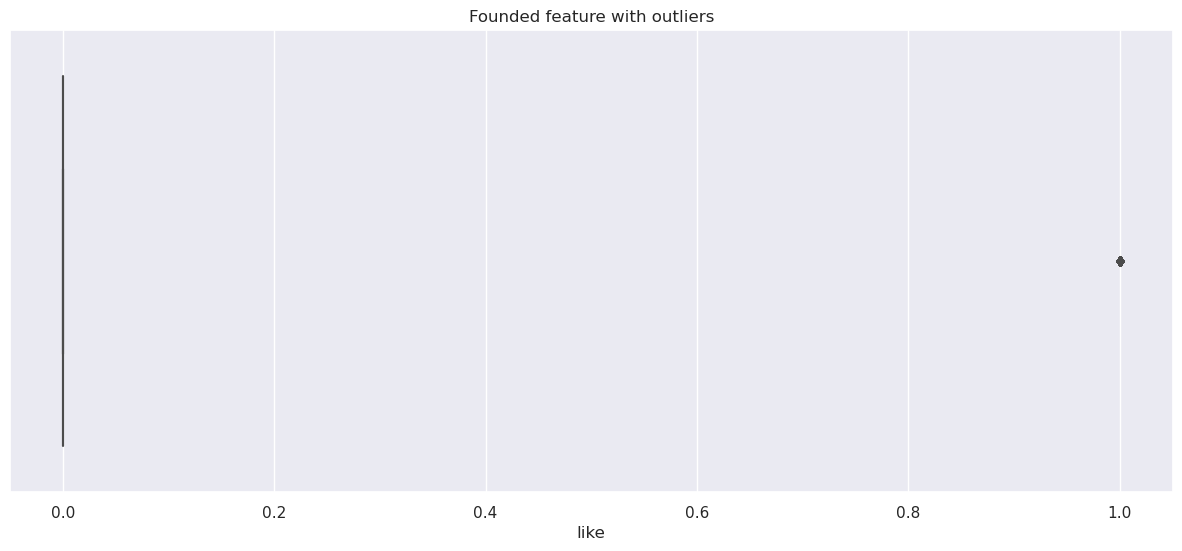

In [22]:
find_outliers(ctr_data_1M['like'])

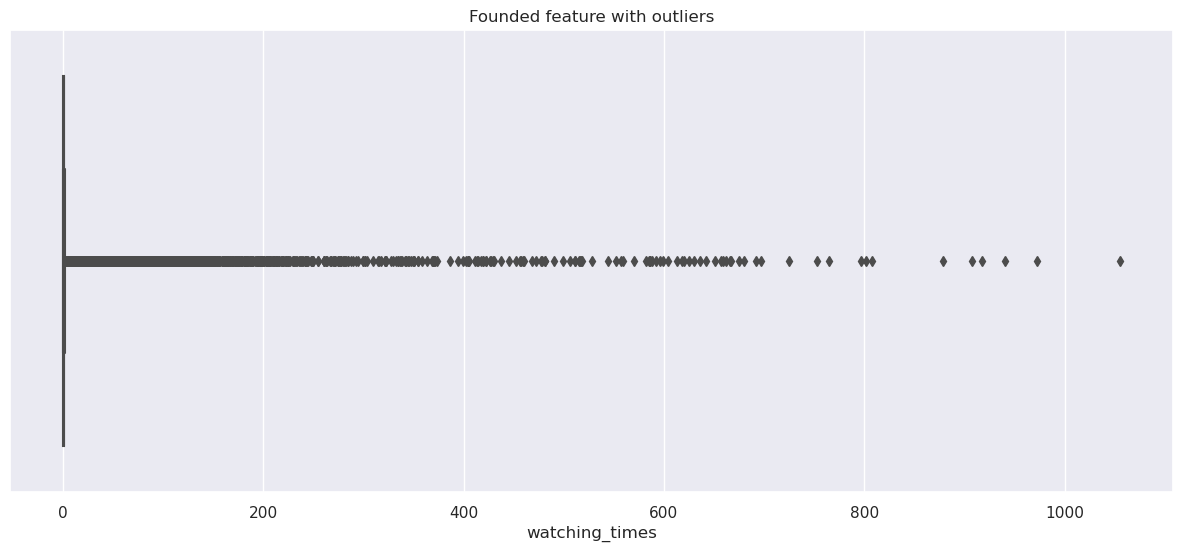

In [24]:
find_outliers(ctr_data_1M['watching_times'])

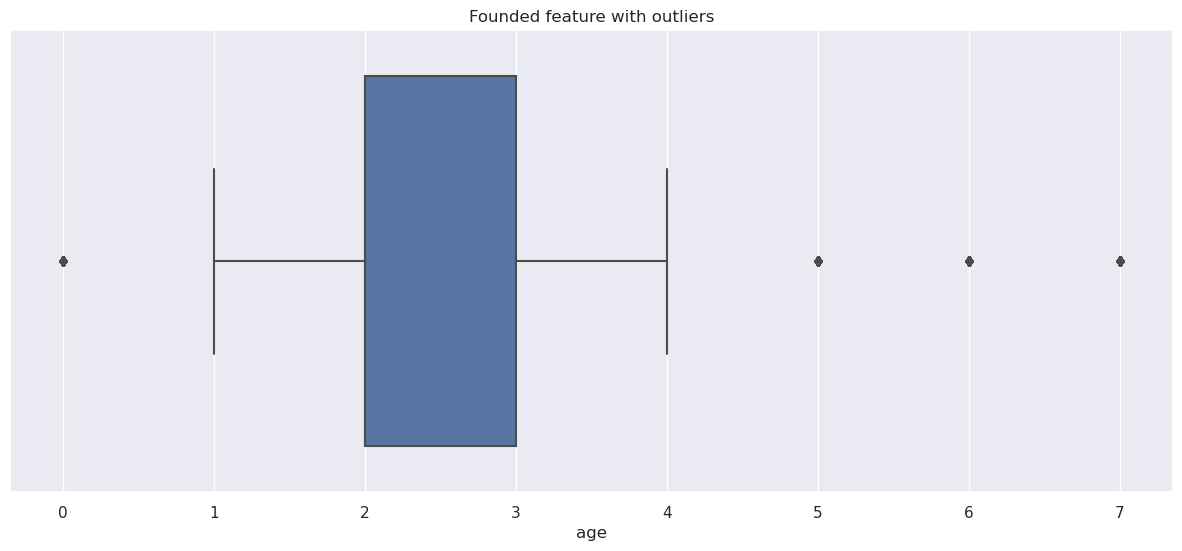

In [25]:
find_outliers(ctr_data_1M['age'])

<Figure size 2000x1000 with 0 Axes>

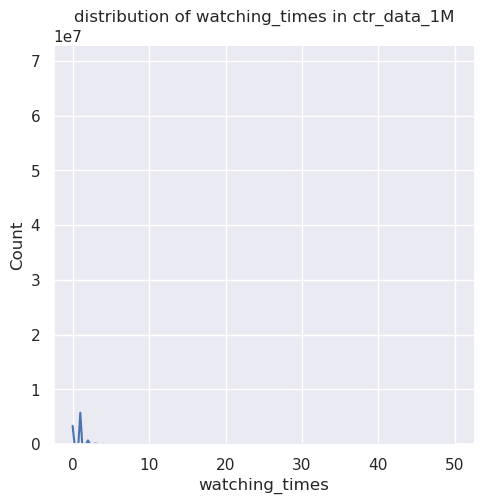

In [31]:
distribution_of_feature(ctr_data_1M['watching_times'][ctr_data_1M['watching_times'] <= 50],'ctr_data_1M','watching_times')

In [32]:
ctr_data_1M.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119458660 entries, 0 to 119458659
Data columns (total 20 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   user_id         int64 
 1   item_id         int64 
 2   click           int64 
 3   follow          int64 
 4   like            int64 
 5   share           int64 
 6   video_category  object
 7   watching_times  int64 
 8   gender          int64 
 9   age             int64 
 10  hist_1          int64 
 11  hist_2          int64 
 12  hist_3          int64 
 13  hist_4          int64 
 14  hist_5          int64 
 15  hist_6          int64 
 16  hist_7          int64 
 17  hist_8          int64 
 18  hist_9          int64 
 19  hist_10         int64 
dtypes: int64(19), object(1)
memory usage: 17.8+ GB


In [35]:
ctr_data_1M['click'].unique()

array([0, 1])

In [39]:
ctr_data_1M['video_category'].unique()

array(['1', '0', '\\N'], dtype=object)

In [40]:
ctr_data_1M['watching_times'].unique()

array([   0,    1,    2,    3,    5,    4,    7,    8,    9,    6,   29,
         20,   12,   22,   11,   33,   13,   59,   28,   14,   17,   10,
         15,   21,  108,   19,   24,  148,   16,   26,   25,   40,   31,
        135,  100,   51,  112,  130,   30,   47,   32,   58,   35,   44,
         23,   18,   41,   37,   49,   74,   75,   45,  386,   81,   69,
         61,   38,   73,   39,   27,   42,   46,  167,  138,   63,   34,
         52,   68,   50,   65,   54,   85,   36,   53,   88,   82,  150,
         48,  156,  107,   76,   98,  146,   43,   57,  172,   64,   70,
         60,   71,   95,   89,   67,  147,   91,  118,  126,  203,  117,
         62,   56,  220,  371,  192,  140,  127,  316,  596,   79,  106,
        239,   72,  219,   66,  422,   80,  137,  102,  121,  164,  201,
        199,   55,  337,   96,   78,  165,  111,   90,  552,  302,   83,
        120,  242,  194,   99,  105,  351,   87,  129,  452,  370,  115,
        195,  570,   92,  359,  725,  592,   93,  2

In [41]:
ctr_data_1M['gender'].unique()

array([1, 2, 0])

In [47]:
ctr_data_1M['hist_10'].unique()

array([   1202,   33178,      29, ..., 1553824,   62026,  519664])

In [49]:
ctr_data_1M['video_category'].value_counts()

video_category
0     64120495
1     53754124
\N     1584041
Name: count, dtype: int64

In [ ]:
ctr_data_1M =ctr_data_1M.drop(ctr_data_1M[ctr_data_1M['video_category'] == '\\N'].index)

In [20]:
ctr_data_1M['video_category'].value_counts()

video_category
0    64120495
1    53754124
Name: count, dtype: int64

In [ ]:
ctr_data_1M['video_category']=ctr_data_1M['video_category'].astype('int64')

In [ ]:
data = pd.read_csv('ctr_data_1M_modified.csv',index_col=0)
data.to_csv('ctr_data_1M_modified.csv',index= False)

In [8]:
#ctr_data_1M = pd.read_csv('ctr_data_1M_modified.csv')
subset= ctr_data_1M.head(100)
subset.to_csv('ctr_data_1M_sample.csv')

In [3]:
data = pd.read_csv('ctr_data_1M_modified.csv',index_col=0)
data

,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age,hist_1,hist_2,hist_3,hist_4,hist_5,hist_6,hist_7,hist_8,hist_9,hist_10
0,1,4,0,0,0,0,1,0,1,4,2,3,80936,781,111774,1230,26403,991,2362,1202
1,1,1201,1,0,0,0,1,1,1,4,2,3,80936,781,111774,1230,26403,991,2362,1202
2,1,250502,1,0,0,0,1,1,1,4,2,3,80936,781,111774,1230,26403,991,2362,1202
3,1,50885,1,0,0,0,1,1,1,4,2,3,80936,781,111774,1230,26403,991,2362,1202
4,1,16934,1,0,0,0,0,1,1,4,2,3,80936,781,111774,1230,26403,991,2362,1202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115787993,961527,1364827,0,0,0,0,1,0,2,2,1466383,1380307,1383378,1675473,1354652,1354559,1369848,0,0,0
115787994,961527,1352546,0,0,0,0,0,1,2,2,1466383,1380307,1383378,1675473,1354652,1354559,1369848,0,0,0
115787995,961527,1377052,0,0,0,0,0,0,2,2,1466383,1380307,1383378,1675473,1354652,1354559,1369848,0,0,0
115787996,961527,1684451,0,0,0,0,0,0,2,2,1466383,1380307,1383378,1675473,1354652,1354559,1369848,0,0,0


# Modeling lightgcn

In [123]:
# Define the nodes and edges of the graph
user_ids = data['user_id']
item_ids = data['item_id']
num_users = len(user_ids)
num_items = len(item_ids)
src, dst = data['user_id'], data['item_id'] + num_users

# Create the graph
graph = dgl.graph((src, dst), num_nodes=num_users + num_items)

# Assign node features
user_feat = data.groupby('user_id').agg({
    'follow':'sum',
    'like': 'sum',
    'share': 'sum',
    'hist': lambda x: list(x)[-10:], # keep only the last 10 items in the user history
    'age': 'mean', # average user age
    'gender': lambda x: x.iloc[0], # use the first gender value for each user
}).reset_index(drop=True)
user_feat = user_feat.fillna(0) # fill missing values with 0
user_feat = user_feat.values.astype(np.float32) # convert to NumPy array
graph.nodes[:num_users].data['feat'] = user_feat

item_feat = ctr_data_1m.groupby('item_id').agg({
    'video_category': lambda x: x.iloc[0], # use the first video_category value for each item
    'watching_times': 'sum', 
}).reset_index(drop=True)
item_feat = item_feat.fillna(0) # fill missing values with 0
item_feat = item_feat.values.astype(np.float32) # convert to NumPy array
graph.nodes[num_users:].data['feat'] = item_feat

# Assign edge weights
graph.edata['ctr'] = ctr_data_1m['click'].values.astype(np.float32)
graph.edata['lik'] = ctr_data_1m['like'].values.astype(np.float32)

KeyError: 42

In [129]:
import networkx as nx
import pandas as pd

# Create a graph
G = nx.Graph()

# Add nodes for users and items
users = data['user_id'].unique()
items = data['item_id'].unique()
G.add_nodes_from(users, bipartite=0)
G.add_nodes_from(items, bipartite=1)

# Add edges for user-item interactions
for _, row in data.iterrows():
    user = row['user_id']
    item = row['item_id']
    weight = row['click'] + row['follow'] + row['like'] + row['share'] + row['watching_times']
    G.add_edge(user, item, weight=weight)

In [128]:
# Create the DGL graph
G = dgl.heterograph({
    ('user', 'interacts', 'item'): (user_item_pairs['user_id'], user_item_pairs['item_id'])
})

# Add node features
num_users = len(user_ids)
num_items = len(item_ids)
num_features = 10

user_features = np.random.rand(num_users, num_features)
item_features = np.random.rand(num_items, num_features)

G.nodes['user'].data['features'] = user_features
G.nodes['item'].data['features'] = item_features

AttributeError: 'numpy.ndarray' object has no attribute 'device'

In [91]:
# Set up the hyperparameter grid
hyperparameters = {
    'embedding_dim': [16, 32, 64],
    'dropout': [0.0, 0.2, 0.4],
    'num_layers': [2, 3, 4],
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [256, 512, 1024]
    'epochs': [10, 20, 30]
}

In [101]:
# Set up the model
yaml_file = 'lightgcn.yaml' # this file is provided by microsoft's recommenders package and it contains the hyperparameters necessary for lightgcn
hparams = prepare_hparams(yaml_file)
model = LightGCN(hparams=hparams, data=train_data)

# Set up the grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Run the grid search
grid_search.fit(train_data)

AttributeError: 'DataFrame' object has no attribute 'get_norm_adj_mat'

In [ ]:
# Print the best hyperparameters and the corresponding scores
best_params, best_score = grid_search.best_params_, np.sqrt(-grid_search.best_score_)
print('Best hyperparameters:', best_params)
print('Best score:', best_score)

In [88]:
# Define the LightGCN-based model
model = LightGCN(HParams, num_layers=3, num_tasks=num_tasks)

# Define the loss function and the optimizer
loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.01)

# Define the training and evaluation functions
@tf.function
def train_step(user_indices, item_indices, labels):
    with tf.GradientTape() as tape:
        task_predictions = model(user_indices, item_indices)
        task_labels = [labels, tf.ones_like(labels)]
        task_losses = [loss_function(task_predictions[i], task_labels[i]) for i in range(num_tasks)]
        loss = sum(task_losses)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

@tf.function
def evaluate(data):
    predictions = [[] for i in range(num_tasks)]
    labels = [[] for i in range(num_tasks)]
    for batch_data in batch_iterator(data):
        user_indices, item_indices, batch_labels = batch_data
        user_indices = tf.convert_to_tensor(user_indices, dtype=tf.int32)
        item_indices = tf.convert_to_tensor(item_indices, dtype=tf.int32)
        batch_labels = tf.convert_to_tensor(batch_labels, dtype=tf.float32)

        task_predictions = model(user_indices, item_indices)
        task_labels = [batch_labels, tf.ones_like(batch_labels)]
        for i in range(num_tasks):
            predictions[i] += task_predictions[i].numpy().tolist()
            labels[i] += task_labels[i].numpy().tolist()

    precision = [precision_score(labels[i], np.round(predictions[i]), average='macro') for i in range(num_tasks)]
    recall = [recall_score(labels[i], np.round(predictions[i]), average='macro') for i in range(num_tasks)]
    f1 = [f1_score(labels[i], np.round(predictions[i]), average='macro') for i in range(num_tasks)]
    map = [mean_average_precision_score(labels[i], predictions[i]) for i in range(num_tasks)]

    return precision, recall, f1, map

def batch_iterator(data, batch_size=1024):
    num_batches = int(np.ceil(len(data) / batch_size))
    for i in range(num_batches):
        batch_data = data[i*batch_size:(i+1)*batch_size]
        user_indices = batch_data['user_id'].values
        item_indices = batch_data['item_id'].values
        labels = batch_data['label'].values
        yield user_indices, item_indices, labels

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = 0.0
    for batch_data in batch_iterator(train_data):
        user_indices, item_indices, labels = batch_data
        loss = train_step(user_indices, item_indices, labels)
        train_loss += loss.numpy()

    # Evaluate the model on the validation data
    val_precision, val_recall, val_f1, val_map = evaluate(val_data)

    print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Precision = {val_precision}, Val Recall = {val_recall}, Val F1 = {val_f1}, Val MAP = {val_map}')

# Evaluate the model on the test data
test_precision, test_recall, test_f1, test_map = evaluate(test_data)

print(f'Test Precision = {test_precision}, Test Recall = {test_recall}, Test F1 ={test_f1}, Test MAP = {test_map}')

NameError: name 'HParams' is not defined

# Modeling ESMM

ESMM Model :

In [4]:
'''
Reference:
    [1]Xiao Ma et al. Entire space multi-task model: An effective approach for estimating post-click conversion rate. In The 41st International
    ACM SIGIR Conference on Research & Development in Information Retrieval, pages 1137–1140, 2018.
Reference:
    https://github.com/busesese/MultiTaskModel
    https://github.com/yuangh-x/2022-NIPS-Tenrec/blob/master/model/mtl/esmm.py
'''

class ESMM(nn.Module):
    def __init__(self, user_feature_dict, item_feature_dict, emb_dim=128, hidden_dim=[128, 128], dropouts=[0.5, 0.5],
                 output_size=1, num_task=2):
        """
        esmm model input parameters
        :param user_feature_dict: user feature dict include: {feature_name: (feature_unique_num, feature_index)}
        :param item_feature_dict: item feature dict include: {feature_name: (feature_unique_num, feature_index)}
        :param emb_dim: int, embedding size
        :param hidden_dim: list of ctr and ctcvr dnn hidden sizes
        :param dropouts: list of ctr and ctcvr dnn drop out probability
        :param output_size: int out put size
        :param num_task: int default 2 multitask numbers
        """
        super(ESMM, self).__init__()

        # check input parameters
        if user_feature_dict is None or item_feature_dict is None:
            raise Exception("input parameter user_feature_dict and item_feature_dict must be not None")
        if isinstance(user_feature_dict, dict) is False or isinstance(item_feature_dict, dict) is False:
            raise Exception("input parameter user_feature_dict and item_feature_dict must be dict")

        self.user_feature_dict = user_feature_dict
        self.item_feature_dict = item_feature_dict
        self.num_task = num_task

        # embedding初始化
        user_cate_feature_nums, item_cate_feature_nums = 0, 0
        for user_cate, num in self.user_feature_dict.items():
            if num[0] > 1:
                user_cate_feature_nums += 1
                setattr(self, user_cate, nn.Embedding(num[0], emb_dim))
        for item_cate, num in self.item_feature_dict.items():
            if num[0] > 1:
                item_cate_feature_nums += 1
                setattr(self, item_cate, nn.Embedding(num[0], emb_dim))

        # user embedding + item embedding
        hidden_size = emb_dim * (user_cate_feature_nums + item_cate_feature_nums) + \
                      (len(user_feature_dict) - user_cate_feature_nums) + (
                                  len(item_feature_dict) - item_cate_feature_nums)

        # esmm 独立任务的DNN结构
        for i in range(self.num_task):
            setattr(self, 'task_{}_dnn'.format(i + 1), nn.ModuleList())
            hid_dim = [hidden_size] + hidden_dim
            for j in range(len(hid_dim) - 1):
                getattr(self, 'task_{}_dnn'.format(i + 1)).add_module('ctr_hidden_{}'.format(j),
                                                                      nn.Linear(hid_dim[j], hid_dim[j + 1]))
                getattr(self, 'task_{}_dnn'.format(i + 1)).add_module('ctr_batchnorm_{}'.format(j),
                                                                      nn.BatchNorm1d(hid_dim[j + 1]))
                getattr(self, 'task_{}_dnn'.format(i + 1)).add_module('ctr_dropout_{}'.format(j),
                                                                      nn.Dropout(dropouts[j]))
            getattr(self, 'task_{}_dnn'.format(i + 1)).add_module('task_last_layer',
                                                                  nn.Linear(hid_dim[-1], output_size))

    def forward(self, x):
        assert x.size()[1] == len(self.item_feature_dict) + len(self.user_feature_dict)
        # embedding
        user_embed_list, item_embed_list = list(), list()
        for user_feature, num in self.user_feature_dict.items():
            if num[0] > 1:
                user_embed_list.append(getattr(self, user_feature)(x[:, num[1]].long()))
            else:
                user_embed_list.append(x[:, num[1]].unsqueeze(1))
        for item_feature, num in self.item_feature_dict.items():
            if num[0] > 1:
                item_embed_list.append(getattr(self, item_feature)(x[:, num[1]].long()))
            else:
                item_embed_list.append(x[:, num[1]].unsqueeze(1))

        # embedding 融合
        user_embed = torch.cat(user_embed_list, axis=1)
        item_embed = torch.cat(item_embed_list, axis=1)

        # hidden layer
        hidden = torch.cat([user_embed, item_embed], axis=1).float()

        # task tower
        task_outputs = list()
        for i in range(self.num_task):
            x = hidden
            for mod in getattr(self, 'task_{}_dnn'.format(i + 1)):
                x = mod(x)
            task_outputs.append(x)

        return task_outputs

Prepare Feature Dictionaries: Create feature dictionaries (user_feature_dict and item_feature_dict) that contain information about the categorical features in the data. Each dictionary should have the format: {feature_name: (feature_unique_num, feature_index)}. 

The feature_unique_num represents the number of unique categories for the feature, and the feature_index represents the column index of the feature in the data.

In [5]:
# Assuming you have loaded the data into a DataFrame named 'data'
# Define the categorical features
categorical_features = ['user_id', 'item_id', 'video_category', 'gender']

# Prepare the feature dictionaries
user_feature_dict = {}
item_feature_dict = {}

for feature in categorical_features:
    unique_categories = data[feature].nunique()
    feature_index = data.columns.get_loc(feature)
    
    if feature.startswith('user'):
        user_feature_dict[feature] = (unique_categories, feature_index)
    elif feature.startswith('item'):
        item_feature_dict[feature] = (unique_categories, feature_index)

# Print the feature dictionaries
print("User Feature Dictionary:")
print(user_feature_dict)
print("\nItem Feature Dictionary:")
print(item_feature_dict)

User Feature Dictionary:
{'user_id': (960945, 0)}

Item Feature Dictionary:
{'item_id': (2133915, 1)}


In [6]:
# Instantiate the ESMM model
esmm_model = ESMM(user_feature_dict, item_feature_dict)

Preparing the data for the ESMM model input by converting it into tensors

In [ ]:
# Select the relevant columns from the DataFrame based on the ESMM model's expected column order
selected_columns = ['user_id', 'item_id', 'click', 'follow', 'like', 'share', 'video_category', 'watching_times',
                    'gender', 'age', 'hist_1', 'hist_2', 'hist_3', 'hist_4', 'hist_5', 'hist_6', 'hist_7',
                    'hist_8', 'hist_9', 'hist_10']

# Prepare the input data as tensors
x = torch.tensor(data[selected_columns].values)

# Print the shape of the input data tensor
print("Shape of input data tensor:", x.shape)

In [ ]:
print(x.shape)

In [ ]:
# Calculate the expected number of features
expected_num_features = len(user_feature_dict) + len(item_feature_dict)

# Print the expected number of features
print("Expected number of features:", expected_num_features)

In [31]:
# Pass the data through the ESMM model
outputs = esmm_model(x)

AssertionError: 

In [ ]:
# Print the outputs
print("Model Outputs:")
for i, output in enumerate(outputs):
    print("Task {}: {}".format(i+1, output))

The outputs will contain the predictions or outputs of each task-specific DNN in the ESMM model. You can use these outputs for evaluation or any other analysis required for your specific task.

Remember to adjust the model and data preparation steps based on the specifics of your dataset and task. The provided code assumes you have the necessary feature dictionaries and data in the appropriate format.